### Initial installations and data mounting

In the cells bellow you install all the appropriate libraries.
For performing instance segmentation your images should be splited in train and test folders and the annotation should be in a simple json file in a COCO format. More instructions you can find below.

In [ ]:
!python -m pip install pyyaml==5.1
# Detectron2 has not released pre-built binaries for the latest pytorch (https://github.com/facebookresearch/detectron2/issues/4053)
# so we install from source instead. This takes a few minutes.
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

# Install pre-built detectron2 that matches pytorch version, if released:
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
#!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/{CUDA_VERSION}/{TORCH_VERSION}/index.html

# exit(0)  # After installation, you may need to "restart runtime" in Colab. This line can also restart runtime

In [ ]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

### Train on a custom dataset

Below we assign our data in the Detectron2

In [ ]:
# if the dataset is in COCO format
from detectron2.data.datasets import register_coco_instances
register_coco_instances("my_train", {}, "xxx.json", "xxx/images")
register_coco_instances("my_val", {}, "xxx.json", "xxx/images")
train_metadata=MetadataCatalog.get("my_train")
dataset_dicts_train=DatasetCatalog.get("my_train")

for d in ["train", "val"]:
    DatasetCatalog.register("balloon_" + d, lambda d=d: get_balloon_dicts("balloon/" + d))
    MetadataCatalog.get("balloon_" + d).set(thing_classes=["balloon"])
balloon_metadata = MetadataCatalog.get("balloon_train")

Visualize your data

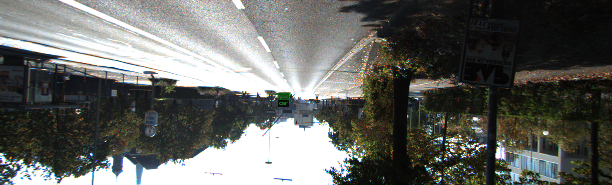

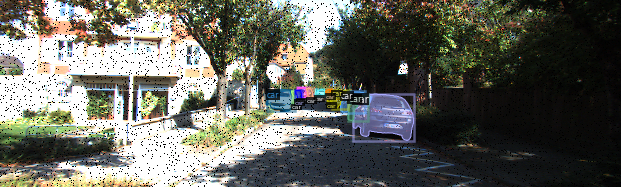

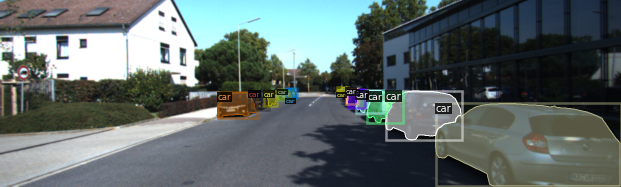

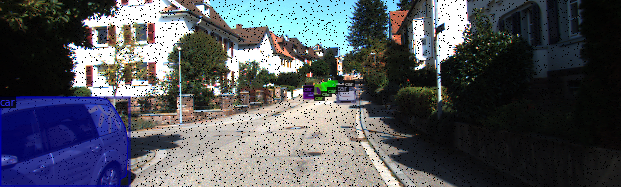

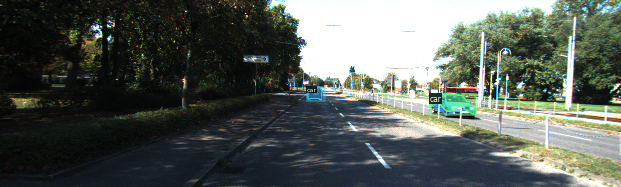

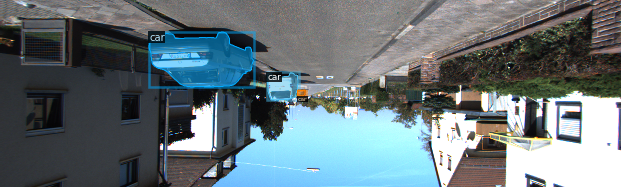

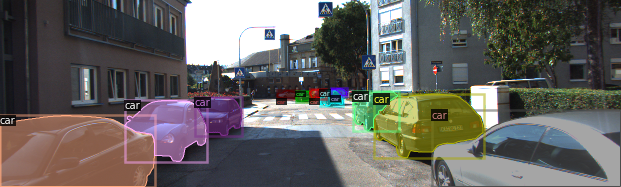

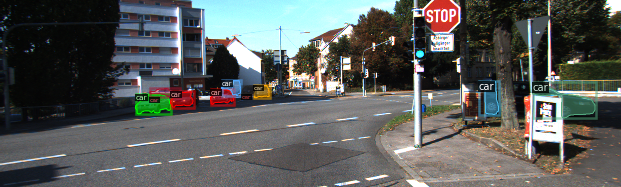

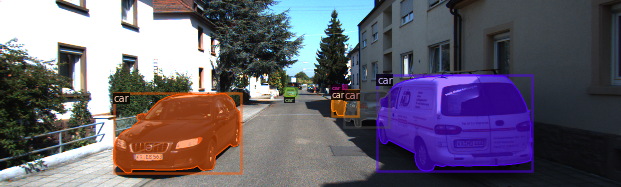

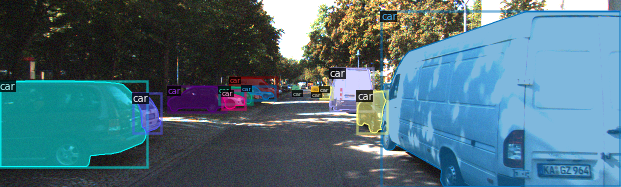

In [ ]:
for d in random.sample(dataset_dicts_train, 10):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=train_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    cv2_imshow(out.get_image()[:, :, ::-1])

In [ ]:
# Different models I'd like to try - https://github.com/facebookresearch/detectron2/blob/master/MODEL_ZOO.md
# models_to_try = {
#     "R50-FPN-1x": "COCO-Detection/faster_rcnn_R_50_FPN_1x.yaml",
#     "R50-FPN-3x": "COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml",
#     "R101-FPN-3x": "COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml",
#     "X101-FPN-3x": "COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml",
#     "RN-R50-1x": "COCO-Detection/retinanet_R_50_FPN_1x.yaml",
#     "RN-R50-3x": "COCO-Detection/retinanet_R_50_FPN_3x.yaml",
#     "RN-R101-3x": "COCO-Detection/retinanet_R_101_FPN_3x.yaml"
# }

In [ ]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("my_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 8  # This is the real "batch size" commonly known to deep learning people
cfg.SOLVER.BASE_LR = 0.001  # pick a good LR
cfg.SOLVER.MAX_ITER = 6000    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512   # The "RoIHead batch size". 128 is faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.


###### For training #######

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
#Use True is something breaks. It will continue from the last checkpoint (the last succesfull model)
trainer.resume_or_load(resume=False)
trainer.train()

In [ ]:
# Look at training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir output

### Inference

In [ ]:
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "xxx/model.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Boxes(tensor([[ 785.7487,  193.0888, 1173.6747,  373.5012],
        [ 666.6917,  186.4803,  725.1884,  232.5791],
        [ 706.6702,  191.0635,  836.7646,  283.5539],
        [ 625.2592,  182.3969,  659.6481,  212.9642],
        [   0.0000,  168.9810,  182.8455,  252.0920],
        [ 280.5949,  184.9168,  325.4783,  211.5850],
        [ 564.6063,  178.5006,  594.3125,  194.0845],
        [ 652.8881,  184.3598,  681.7921,  222.2539],
        [ 216.4949,  183.1248,  278.9944,  199.9235],
        [ 319.5025,  171.7103,  372.8565,  202.3497],
        [ 361.2958,  168.2125,  404.0689,  196.3851],
        [ 421.8023,  180.7246,  471.9297,  196.6757]], device='cuda:0'))


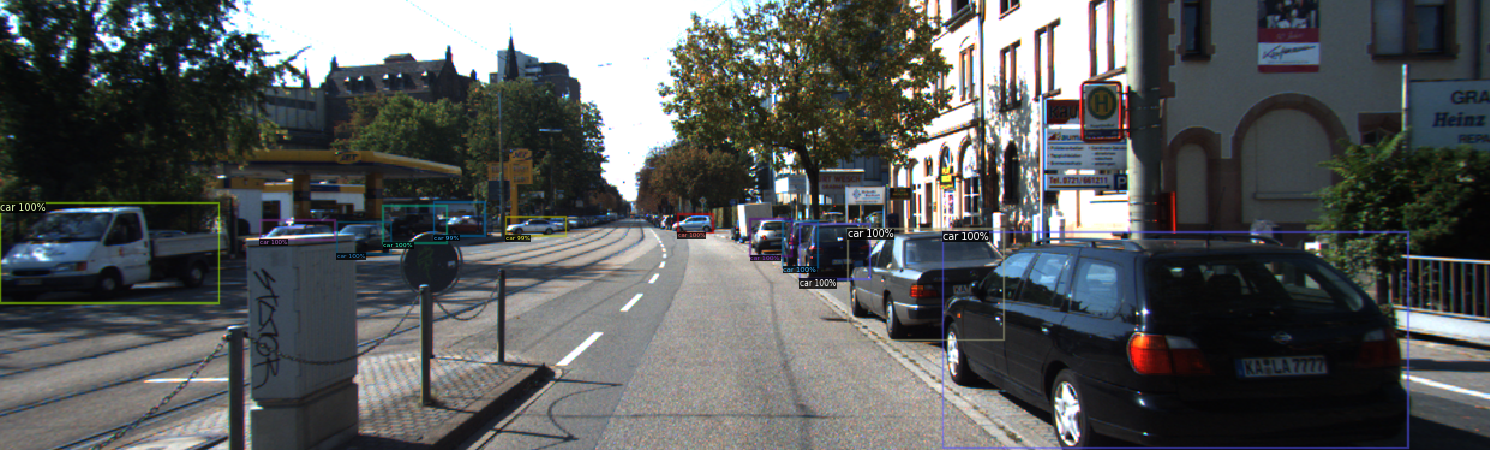

In [ ]:
#Check on a total new image
im = cv2.imread("xxx/000035.png")
outputs = predictor(im)
print(outputs["instances"].pred_classes)
print(outputs["instances"].pred_boxes)
#print(outputs["instances"].pred_masks)
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(out.get_image()[:, :, ::-1])

In [ ]:
# Run on validation dataset (predict on validation)

from detectron2.utils.visualizer import ColorMode
dataset_dicts_val=DatasetCatalog.get("my_val")
val_metadata=MetadataCatalog.get("my_val")
for d in random.sample(dataset_dicts_val, 13):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1],
                   metadata=val_metadata, 
                   scale=0.5, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])

In [ ]:
#Evaluation - Look at AveragePrecision(AP)
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("my_val", output_dir="/content/output")
val_loader = build_detection_test_loader(cfg, "my_val")
print(inference_on_dataset(predictor.model, val_loader, evaluator))
